# **PART A**

### **Objective:** To build a face detection system.

### Importing required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Loading the data

In [ ]:
#Loading the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = np.load('drive/MyDrive/Datasets/images.npy', allow_pickle=True)

In [ ]:
images.shape

(409, 2)

* Dataset contains 409 images with its corresponding labels and mask coordinates.

### Seperating images and labels

In [ ]:
just_images = images[:,0]

In [ ]:
labels = images[:,1]

In [ ]:
just_images[272].shape

(350, 650)

In [ ]:
just_images[0].shape

(333, 650, 3)

In [ ]:
just_images[1].shape

(697, 1280, 4)

### Data Observations:

* The images are in varied shapes. Since we' re planning on using MobileNetV2 as our backbone architecture, it should be converted to the shape 224*224*3

* Few samples consists of alpha channels(having an extra dimension), and there are images with only one channel.

* To keep the model simplicity and also that, there are only few samples with alpha channel and grayscale - all images will be converted to 224*224*3

### Visualing and understanding the data

* The image data consists different sorts of varieties, ranging from common photo albums to movie poster(highly edited).

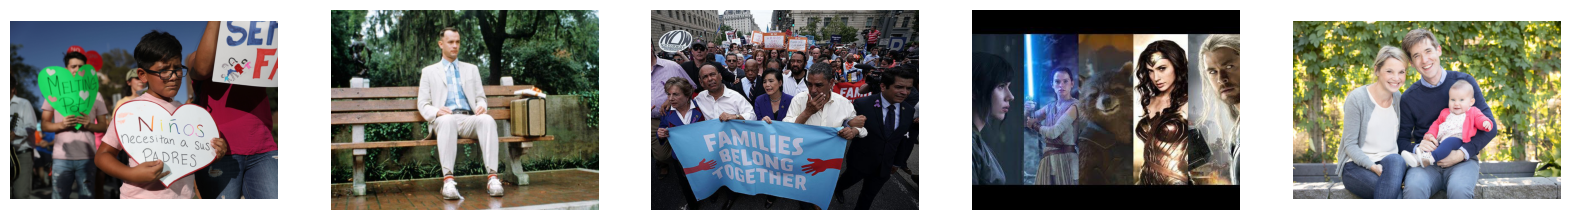

In [ ]:
Random_five_images = np.random.randint(just_images.shape[0], size=5)
plt.figure(figsize=(20, 8))
for idx, image in enumerate(Random_five_images):
  plt.subplot(1, 5, idx+1)
  plt.imshow(just_images[image])
  plt.axis('off')
plt.show()

### Transformations:

* Using pytorch Dataset class to deal with the issue of RAM and also it offers more flexibility.
* Resizing the data to 224*224*3
* Normalizing the data by specific mean and std appropriate to MobileNet architecture.
* Creating a mask which will be used as target in our model.

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
                                ])

In [ ]:
class segmentationDataset(Dataset):
  def __init__(self, image_file, labels, transform=None):
    self.image_file = image_file
    self.labels = labels
    self.transform = transform
    self.transform_alpha = transforms.Lambda(lambda x: x[:3])
    self.transform_grayscale = transforms.Lambda(lambda x: x.expand(3,*x.shape[1:]))
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  def __len__(self):
    return(self.image_file.shape[0])

  def __getitem__(self, idx):
    masked_im = self.image_file[idx]
    labels_m = self.labels[idx]

    if self.transform is not None:
      train_im = self.transform(masked_im)
      if train_im.size(0) == 4 :
        train_im = self.transform_alpha(train_im)
      if train_im.size(0) == 1:
        train_im = self.transform_grayscale(train_im)
      train_im = self.normalize(train_im)
      _masked_im = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH))

      for label in labels_m:
        _masked_im[round(label['points'][0]['y']*224):round(label['points'][1]['y']*224), round(label['points'][0]['x']*224):round(label['points'][1]['x']*224)] = 1

    return (train_im, _masked_im)

###Applying transformation and Splitting the data into 400 training images and 9 test images.


In [ ]:
train_ds = segmentationDataset(just_images[:400], labels[:400], transform)
test_ds  = segmentationDataset(just_images[400:], labels[400:], transform)

In [ ]:
BATCH_SIZE = 16
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=1)

### Visualizing masked image

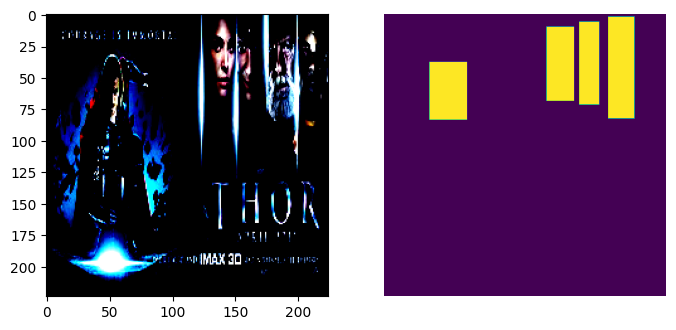

In [ ]:
Random_image = np.random.randint(just_images.shape[0], size=1)
fig = plt.figure(figsize=(8, 8))

fig.add_subplot(1, 2, 1)
plt.imshow(train_ds[Random_image[0]][0].permute(1,2,0))
fig.add_subplot(1, 2, 2)
plt.imshow(train_ds[Random_image[0]][1])
plt.axis('off')
plt.show()

* In the above image, we can see corresponding face masks for all the faces.
* Image looks different because we normalized with different mean and standard deviation required by mobilenet pretrained model.

### Building our model:

### MODEL 1:

* Designing unet with pretrained mobilenet

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
if torch.cuda.is_available():
    model.cuda()
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 48.5MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### Removing the classifier layer

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [ ]:
model.classifier = Identity()
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
class Unet(nn.Module):
    def __init__(self, pretrained_net, n_class):
        super().__init__()

        self.backbone = pretrained_net

        self.dconv1 = nn.ConvTranspose2d(1280, 96, 4, padding=1, stride=2)
        self.conv1  = nn.Conv2d(192, 192, 3, 1, 1)
        self.BN1 = nn.BatchNorm2d(192)

        self.dconv2 = nn.ConvTranspose2d(192, 32, 4, padding=1, stride=2)
        self.conv2  = nn.Conv2d(64, 64, 3, 1, 1)
        self.BN2 = nn.BatchNorm2d(64)

        self.dconv3 = nn.ConvTranspose2d(64, 24, 4, padding=1, stride=2)
        self.conv3  = nn.Conv2d(48, 48, 3, 1, 1)
        self.BN3 = nn.BatchNorm2d(48)

        self.dconv4 = nn.ConvTranspose2d(48, 16, 4, padding=1, stride=2)
        self.conv4  = nn.Conv2d(32, 32, 3, 1, 1)
        self.BN4 = nn.BatchNorm2d(32)

        self.dconv5 = nn.ConvTranspose2d(32, 3, 4, padding=1, stride=2)
        self.conv5  = nn.Conv2d(6, 6, 3, 1, 1)
        self.BN5 = nn.BatchNorm2d(6)

        self.conv_layer = nn.Conv2d(6, 3, 1)
        self.conv_score = nn.Conv2d(3, 1, 1)

    def forward(self, x):
        x0  = x

        for n in range(0, 2):
            x = self.backbone.features[n](x)
        x1 = x

        for n in range(2, 4):
            x = self.backbone.features[n](x)
        x2 = x

        for n in range(4, 7):
            x = self.backbone.features[n](x)
        x3 = x

        for n in range(7, 14):
            x = self.backbone.features[n](x)
        x4 = x

        for n in range(14, 19):
            x = self.backbone.features[n](x)
        x5 = x

        up1 = torch.cat([
            x4,
            self.dconv1(x)
        ], dim=1)
        up1 = F.relu(self.conv1(up1))
        up1 = self.BN1(up1)
        up1 = F.relu(self.conv1(up1))
        up1 = self.BN1(up1)

        up2 = torch.cat([
            x3,
            self.dconv2(up1)
        ], dim=1)
        up2 = F.relu(self.conv2(up2))
        up2 = self.BN2(up2)
        up2 = F.relu(self.conv2(up2))
        up2 = self.BN2(up2)

        up3 = torch.cat([
            x2,
            self.dconv3(up2)
        ], dim=1)
        up3 = F.relu(self.conv3(up3))
        up3 = self.BN3(up3)
        up3 = F.relu(self.conv3(up3))
        up3 = self.BN3(up3)

        up4 = torch.cat([
            x1,
            self.dconv4(up3)
        ], dim=1)
        up4 = F.relu(self.conv4(up4))
        up4 = self.BN4(up4)
        up4 = F.relu(self.conv4(up4))
        up4 = self.BN4(up4)

        up5 = torch.cat([
            x0,
            self.dconv5(up4)
        ], dim=1)
        up5 = F.relu(self.conv5(up5))
        up5 = self.BN5(up5)

        x = self.conv_layer(up5)
        x = self.conv_score(x)

        x = torch.sigmoid(x)

        return x


In [ ]:
unet = Unet(pretrained_net=model, n_class=1)
if torch.cuda.is_available():
    unet.cuda()

### MODEL 2:

* Using pretrained Unet with mobilenet with 'imagenet' weights:

In [ ]:
# !pip install segmentation_models_pytorch

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
N_CLASSES = 1

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=N_CLASSES,
    activation=ACTIVATION,
)
if torch.cuda.is_available():
    model.cuda()

### Desiging Dice coeffcienet and Loss with Binary Cross Entropy:

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        #inputs = F.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs.double(), targets.double(), reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

### Setting up Hyperparameters:

### MODEL 1:

In [ ]:
lossFunc = DiceBCELoss()
LR_RATE = 0.001
NUM_EPOCH = 18
opt = torch.optim.Adam(unet.parameters(), lr = LR_RATE)

### MODEL 2:

In [ ]:
lossFunc = DiceBCELoss()
LR_RATE = 0.001
NUM_EPOCH = 20
opt = torch.optim.Adam(model.parameters(), lr = LR_RATE)

In [ ]:
train_loss = []

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training the model

In [ ]:
for e in range(NUM_EPOCH):
	unet.train()
	totalTrainLoss = 0
	for (i, (x, y)) in enumerate(train_dl):

		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		pred = unet(x)

		loss = lossFunc(pred, y)

		opt.zero_grad()
		loss.backward()
		opt.step()

		totalTrainLoss += loss

		avgTrainLoss = totalTrainLoss / len(train_ds)

		train_loss.append(avgTrainLoss.cpu().detach().numpy())


### Plotting Loss

### My own UNET model with pretrained mobilenet(18 epochs, Adam, LR: 0.001): => MODEL 1

Text(0.5, 1.0, 'Dice loss with BCE')

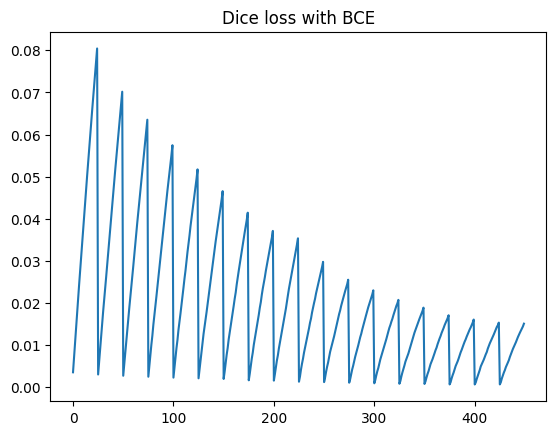

In [ ]:
plt.plot(train_loss)
plt.title('Dice loss with BCE')

### Pretrained mobilenet with unet segmentation models pytorch(20 epochs, Adam, LR: 0.001): => MODEL 2

Text(0.5, 1.0, 'Dice loss with BCE')

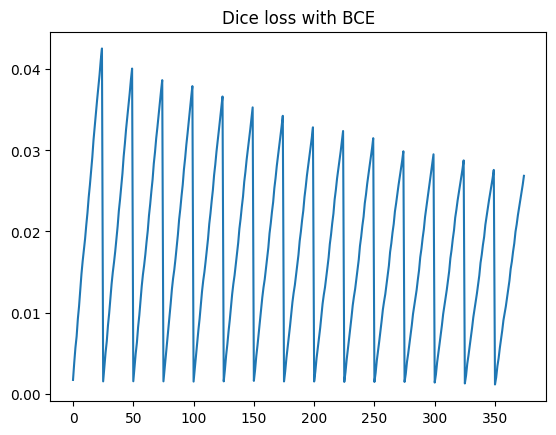

In [ ]:
plt.plot(train_loss)
plt.title('Dice loss with BCE')

#### Performance of the model:

*In both models*
*  Loss shows more spikes due to the varieties in image data.

*In MODEL 1*
*  There seems to be a steady decrease in the loss apporximately from 0.08 to 0.015(Considering just the spikes) which shows our model is consistently learning.

*In MODEL 2*
*  There seems to be a steady decrease in the loss apporximately from 0.04 to 0.03(Considering just the spikes). Though the loss seems to be little bit larger than model 1, due to its holistic pretrained nature in both mobilenet and unet architecture, it generalizes well which can be seen below in visualization section.

### Inference:

In [ ]:
test_image = test_ds[3][0]

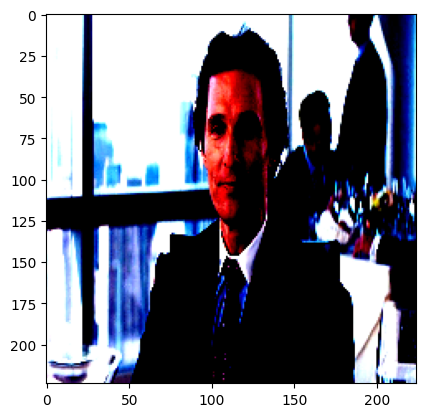

In [ ]:
plt.imshow(test_image.permute(1,2,0))

### Visualizing by placing predicted segementation on the face

### MODEL 1:

(-0.5, 223.5, 223.5, -0.5)

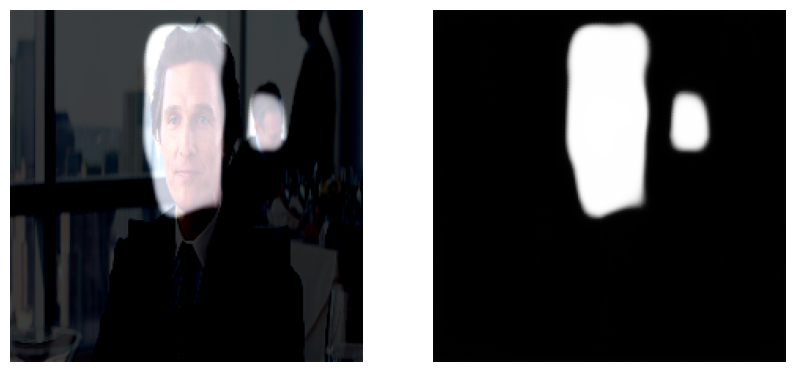

In [ ]:
unet.eval()

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
test_image = test_ds[3][0]
prediction = unet(test_image.to(DEVICE).unsqueeze(0))
test_pred = prediction.squeeze(0).permute(1,2,0).cpu().detach().numpy()
test_pred = cv2.merge((test_pred, test_pred, test_pred))
test_image = test_image.permute(1,2,0).cpu().detach().numpy()
im_blend = cv2.addWeighted(test_image, 0.1, test_pred, 0.9, 0)
plt.axis('off')
plt.imshow(im_blend)

plt.subplot(1,2,2)
plt.imshow(test_pred)
plt.axis('off')

### MODEL 2:

(-0.5, 223.5, 223.5, -0.5)

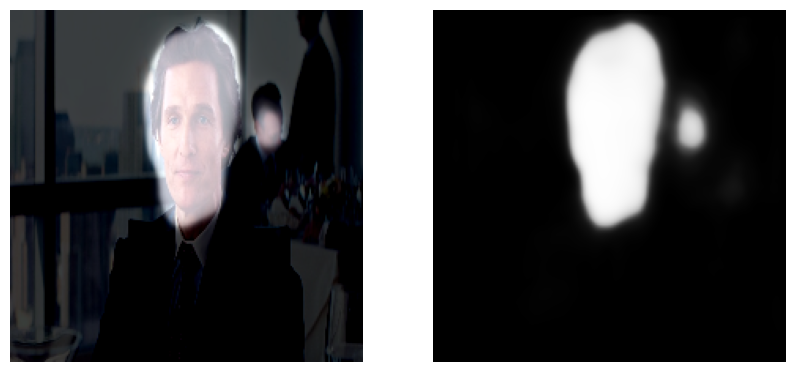

In [ ]:
model.eval()

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
test_image = test_ds[3][0]
prediction = model(test_image.to(DEVICE).unsqueeze(0))
test_pred = prediction.squeeze(0).permute(1,2,0).cpu().detach().numpy()
test_pred = cv2.merge((test_pred, test_pred, test_pred))
test_image = test_image.permute(1,2,0).cpu().detach().numpy()
im_blend = cv2.addWeighted(test_image, 0.1, test_pred, 0.9, 0)
plt.axis('off')
plt.imshow(im_blend)

plt.subplot(1,2,2)
plt.imshow(test_pred)
plt.axis('off')

### MODEL 1:

* We can still see the resemblance of rectangular shape because our UNET layers have been only trained on our rectangular masks.
* Though it could predict some non linear shapes especially right cheek side of the prominent person.
* The model captured the difference between two faces in the picture.

### MODEL 2:

* As this model has pretrained weight holistically with respect to mobilenet and unet, it predicted non linear shapes and shows a rough contour around his face.

* Though the loss is little bit bigger than model 1, model 2 generalized well than model 1.

*In both cases*

* My hypothesis: Though we gave only rectangular coordinates in our target, some coordinates contained informations on different parts of face(hair, ears, different types of chins etc.,), which our model used to predict hair and other nonlinear shapes(Especially MODEL 1).